In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import os

2025-11-11 14:58:54.675988: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-11 14:58:55.089556: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-11 14:59:01.691556: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
train_dir = r"Training"
valid_dir = r"Validation"
test_dir  = r"Testing"

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.6, 1.4],
    fill_mode='nearest'
)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224,224), batch_size=32,
    class_mode='categorical', shuffle=True
)
valid_generator = valid_datagen.flow_from_directory(
    valid_dir, target_size=(224,224), batch_size=32,
    class_mode='categorical', shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(224,224), batch_size=32,
    class_mode='categorical', shuffle=False
)

Found 10888 images belonging to 2 classes.
Found 985 images belonging to 2 classes.
Found 923 images belonging to 2 classes.


In [5]:
cw = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(cw))
print("Class Weights:", class_weights)

Class Weights: {0: 1.4030927835051545, 1: 0.7768264840182648}


In [6]:
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)
base_model.trainable = False  # Freeze base layers

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

2025-11-11 15:00:16.587419: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5,
                               restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=2, verbose=1, min_lr=1e-6)

In [8]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)


/home/vagdevireddy/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 433s 1s/step - accuracy: 0.6420 - loss: 0.6757 - val_accuracy: 0.7472 - val_loss: 0.5238 - learning_rate: 1.0000e-04
Epoch 2/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 359s 1s/step - accuracy: 0.7100 - loss: 0.5602 - val_accuracy: 0.7695 - val_loss: 0.4875 - learning_rate: 1.0000e-04
Epoch 3/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 172s 502ms/step - accuracy: 0.7320 - loss: 0.5399 - val_accuracy: 0.7777 - val_loss: 0.4768 - learning_rate: 1.0000e-04
Epoch 4/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 168s 491ms/step - accuracy: 0.7448 - loss: 0.5216 - val_accuracy: 0.7787 - val_loss: 0.4620 - learning_rate: 1.0000e-04
Epoch 5/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 169s 496ms/step - accuracy: 0.7573 - loss: 0.5018 - val_accuracy: 0.7980 - val_loss: 0.4608 - learning_rate: 1.0000e-04
Epoch 6/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 167s 491ms/step - accuracy: 0.7588 - loss: 0.4983 - val_accuracy: 0.7817 - val_loss: 0.4641 - learning_rate: 1.0000e-04
Epoch 7/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 167s 4

29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 422ms/step - accuracy: 0.8494 - loss: 0.3255
Test Accuracy: 84.94%  |  Test Loss: 0.3255


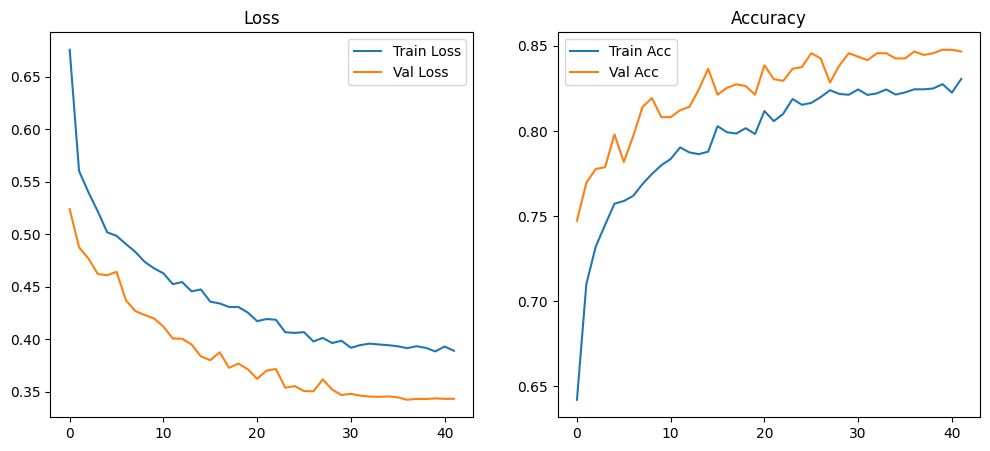

29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 409ms/step
Confusion Matrix:
 [[429  56]
 [ 83 355]]
Classification Report:
                  precision    recall  f1-score   support

bleached_corals       0.84      0.88      0.86       485
 healthy_corals       0.86      0.81      0.84       438

       accuracy                           0.85       923
      macro avg       0.85      0.85      0.85       923
   weighted avg       0.85      0.85      0.85       923



In [9]:
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%  |  Test Loss: {loss:.4f}")

# 📈 Plot training curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy')
plt.show()

# 🔍 Confusion Matrix
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n",
      classification_report(y_true, y_pred,
                            target_names=list(test_generator.class_indices.keys())))


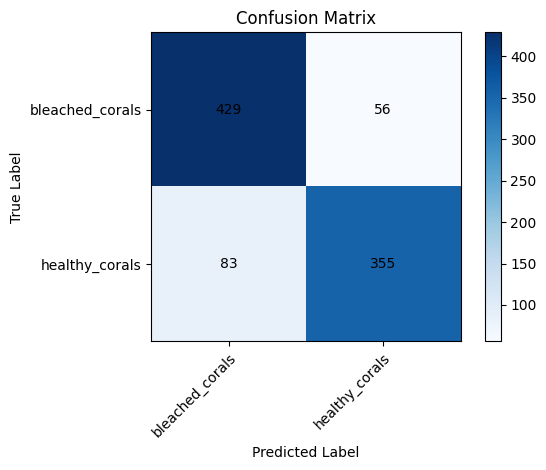

In [10]:
# Plot CM
classes = list(test_generator.class_indices.keys())
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')
ax.figure.colorbar(im, ax=ax)
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [11]:

# 💾 Save Model
model.save("CNN_model_MobileNet_CoralsClassification.h5")

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("CNN_model_MobileNet_CoralsClassification.tflite", "wb").write(tflite_model)
print("Model saved successfully (.h5 + .tflite)")

INFO:tensorflow:Assets written to: /tmp/tmpfu9i0qpk/assets


INFO:tensorflow:Assets written to: /tmp/tmpfu9i0qpk/assets


Saved artifact at '/tmp/tmpfu9i0qpk'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  132750494473328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132750494540272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132750494538160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132750494536224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132750494537632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132750494546256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132750494544672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132750494542560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132750494543440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132750494546080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1327504945

W0000 00:00:1762860991.008068  191444 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1762860991.008716  191444 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-11-11 17:06:31.011975: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpfu9i0qpk
2025-11-11 17:06:31.022915: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-11-11 17:06:31.022942: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpfu9i0qpk
I0000 00:00:1762860991.084919  191444 mlir_graph_optimization_pass.cc:437] MLIR V1 optimization pass is not enabled
2025-11-11 17:06:31.099370: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-11-11 17:06:31.624062: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpfu9i0qpk
2025-11-11 17:06:31.748670: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 